# Lale: Language for Automated Learning Exploration

### Git Repo: https://github.ibm.com/aimodels/lale


This tutorial is meant to be used as a quick start guide for Lale by data scientists familiar with the scikit-learn library.


## Value Proposition

The **target user** of Lale is the working data scientist. The
**scope** of Lale includes machine learning (both deep learning and
non-DL) and data preparation. The **value** of Lale encompasses:

<img src="img/2019-0717-four-values.jpg" style="width:100%" align="center">

## Installation


Please follow the installation instructions at https://github.ibm.com/aimodels/lale

## Terminology

* Operator: An operator is an implementation of a machine learning algorithm. The term operator can be used to indicate a transformer or an estimator from scikit-learn or any other implementation. 

## A simple example of classification

### Dataset

The example shows how to use a dataset from scikit-learn for classification. Lale provides easy access to some standard datasets in its lale.datasets package. In theory, user can use any dataset appropriate for a task as long as it is compatible with the algorithms operating on those. For structured datasets, most common formats supported by Lale are Numpy ndarrays and Pandas dataframes.

In [1]:
import sklearn.datasets
X, y = sklearn.datasets.load_iris(return_X_y=True)

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y)    

### Classifiers

Lale provides wrappers to many scikit-learn algorithms. All these wrappers can be accessed from lale.lib.sklearn with the same name as the original scikit-learn class name. For example, "from lale.lib.sklearn import LogisticRegression". Jump to the FAQ section below if such an import statement for your favorite algorithm fails.

The example below illustrates use of LogisticRegression from Lale with the scikit-learn compatible fit and predict apis.

In [3]:
from lale.lib.sklearn import LogisticRegression
clf = LogisticRegression(solver='liblinear', C=0.9)
trained_clf = clf.fit(X_train, y_train)
predictions = trained_clf.predict(X_test)

In [4]:
from sklearn.metrics import accuracy_score
print('accuracy {:.1%}'.format(accuracy_score(y_test, predictions)))

accuracy 89.5%


### Interactive Documentation

Below are some examples of interactive documentation provided by Lale on the operators.

In [5]:
print(LogisticRegression.hyperparam_defaults())

{'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'auto', 'verbose': 0, 'warm_start': False, 'n_jobs': None}


In [6]:
LogisticRegression.hyperparam_schema('C')

{'description': 'Inverse regularization strength. Smaller values specify stronger regularization.',
 'type': 'number',
 'distribution': 'loguniform',
 'minimum': 0.0,
 'exclusiveMinimum': True,
 'default': 1.0,
 'minimumForOptimizer': 0.03125,
 'maximumForOptimizer': 32768}

## Pipelines

Lale allows data scientists to represent combinations of operators as pipelines. Unlike scikit-learn pipelines, there are no restrictions on Lale pipelines in the sequence of transformers and estimators or the shape of the pipeline (any directed acyclic graph is accommodated). Lale pipeline is a lot more flexible and provides advanced features which will be discussed in other advanced Lale tutorials.

Lale pipelines can be created using `make_pipeline` similar to scikit-learn. There are also some composition operators listed below which can be used to create complex pipelines with easy syntax.

| Symbol | Name | Description  | Sklearn feature |
| ------ | ---- | ------------ | --------------- |
| >>     | pipe | Feed to next | `make_pipeline` |
| &      | and  | Run both     | `make_union`, includes concat |
| &#x7c; | or   | Choose one   | (missing) |

The example below shows how to combine feature selection/pre-processing and classification in a pipeline and use it to train and predict on the given dataset.

In [7]:
from lale.lib.sklearn import StandardScaler,  PCA
from lale.lib.xgboost import XGBClassifier
from lale.operators import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [8]:
lale_pipeline = StandardScaler() >> PCA(n_components = 3) >> XGBClassifier()

or

In [9]:
lale_pipeline = make_pipeline(StandardScaler(), PCA(n_components = 3), XGBClassifier())

You can visualize a Lale pipeline using graphviz as follows:

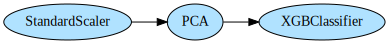

In [10]:
from lale.helpers import to_graphviz
to_graphviz(lale_pipeline)

In [11]:
trained_pipeline = lale_pipeline.fit(X_train, y_train)
predictions = trained_pipeline.predict(X_test)

## Combined algorithm selection and hyper-parameter tuning (CASH)

Lale provides out-of-the-box support for 3 popular optimizers (grid search, Hyperopt, SMAC) for combined algorithm selection and hyper-parameter tuning. Users have to choose the algorithms and pipeline structure they want to consider, and Lale can select the best performing algorithms and hyper-parameter combination from those. If users would like some fixed values of hyper-parameters, they can create the operator objects with those values and the tuning step won't tune that hyper-parameter. There are more advanced ways to over-ride the search spaces, but we defer that discussion to Lale advanced tutorials.

The examples below show a typical CASH usage with Lale for our classification example. We show use of Hyperopt and grid search in the examples. SMAC is another optimizer supported by Lale, but we omit it for this tutorial since installation of SMAC is non trivial for some platforms.

Note that the example below is using the `|` operator to indicate the choice of operators. And `NoOp` here means `No Operation`.

In [12]:
from lale.lib.lale import NoOp
from lale.lib.sklearn import MinMaxScaler, GradientBoostingClassifier, KNeighborsClassifier, RandomForestClassifier, \
ExtraTreesClassifier
lale_pipeline = (NoOp() | MinMaxScaler() | StandardScaler()) >> \
                (NoOp() | PCA()) >> \
                (GradientBoostingClassifier(loss='deviance') | KNeighborsClassifier() | RandomForestClassifier() | ExtraTreesClassifier())

HyperoptClassifier used below is a Lale operator defined to use Hyperopt for classification. There is lale.lib.lale.HyperoptRegressor for regression. Users can use Hyperopt for other tasks by following those examples and a detailed discussion of those can be found in Lale advanced tutorials.

The HyperoptClassifier takes the lale pipeline as input and has a parameter `max_evals` to refer to the number of iterations of pipeline tuning. For example, `max_evals = 10` would consider 10 different configurations of the given pipeline and output the best of those. Note that it is using `accuracy` as a metric while choosing the best pipeline.

Lale helps to minimize the number of invalid runs out of those `max_evals` number of iterations, but there could still be some such runs. HyperoptClassifier will output a warning in such cases, set the accuracy to zero corresponding to that run and continue to the next run.

In [13]:
from lale.lib.lale.hyperopt_classifier import HyperoptClassifier
optimizer = HyperoptClassifier(model=lale_pipeline, max_evals=10)
trained = optimizer.fit(X_train, y_train)

100%|██████████| 10/10 [00:25<00:00,  3.03s/it, best loss: -0.9733333333333333]


Visualizing the `trained` pipeline output shows that Hyperopt picked PCA followed by KNeighborsClassifier for this dataset after 10 iterations of tuning.

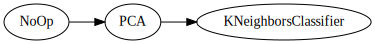

In [14]:
to_graphviz(trained)

You can inspect the best hyper-parameter values that the tuning selected as follows:

In [15]:
trained.to_json()

{'class': 'lale.operators.TrainedPipeline',
 'state': 'trained',
 'edges': [[0, 1], [1, 2]],
 'steps': [{'class': 'lale.lib.lale.no_op.NoOpImpl',
   'state': 'trained',
   'operator': 'NoOp',
   'documentation_url': 'https://github.ibm.com/aimodels/lale',
   'hyperparams': {}},
  {'class': 'lale.lib.sklearn.pca.PCAImpl',
   'state': 'trained',
   'operator': 'PCA',
   'documentation_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html',
   'hyperparams': {}},
  {'class': 'lale.lib.sklearn.k_neighbors_classifier.KNeighborsClassifierImpl',
   'state': 'trained',
   'operator': 'KNeighborsClassifier',
   'documentation_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html',
   'hyperparams': {'algorithm': 'ball_tree',
    'n_neighbors': 22,
    'p': 1,
    'weights': 'distance'}}]}

Lale also generates the input parameter grid for GridSearchCV automatically and has a wrapper for scikit-learn's GridSearchCV. It can be used as follows:

In [16]:
from lale.search.GridSearchCV import LaleGridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

grid_search = LaleGridSearchCV(lale_pipeline, lale_num_samples=1, lale_num_grids=1, cv=2,
                scoring=make_scorer(accuracy_score))
trained = grid_search.fit(X_train, y_train)

The following example illustrates union of operators followed by `ConcatFeatures` which concats their output. The combination works similar to `FeatureUnion` from scikit-learn. Here, the output of PCA and Nystroem is concatenated together and passed to the classifier.

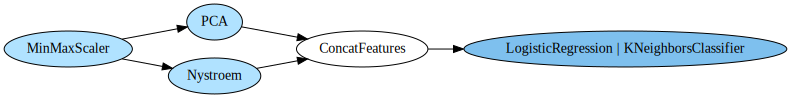

In [17]:
from lale.lib.lale import ConcatFeatures
from lale.lib.lale import NoOp
from lale.lib.sklearn import MinMaxScaler
from lale.lib.sklearn import Nystroem

def my_pipeline(scale=False, n_components=10, clf=LogisticRegression()):
    scl = MinMaxScaler(feature_range=(0, 1)) if scale else NoOp
    pca = PCA(n_components=n_components)
    nys = Nystroem(n_components=n_components)
    return scl >> (pca & nys) >> ConcatFeatures >> clf

optimizable = my_pipeline(True, 3, LogisticRegression() | KNeighborsClassifier())
to_graphviz(optimizable)

Note: If you notice different colors in the nodes of the above graphviz visualization, this is an important feature of Lale, called lifecycle stages, more details can be found in Lale advanced tutorials.

## Other ML tasks

The core Lale functionality demonstrated above works the same way for the tasks below. Also, the example above mostly demonstrates algorithms from scikit-learn, but Lale also has operators based on other frameworks including some deep learning implementations. Please slack **#lale-users** for more details or browse Lale git repository at **https://github.ibm.com/aimodels/lale** for more information.

* **Regression on tabular data**
* **Sequence/time-series classification/regression**
* **Text classification**
* **Image classification**

## FAQ

* **The algorithm I want to use is not present in Lale. Can I still use it?**

    Some of the features of Lale can be used if the algorithm implementation follows a scikit-learn API of fit/predict or fit/transform. You can cast the operator into a Lale operator as follows:

```python
from lale.operators import make_operator

lale_op = make_operator(non_lale_op)
```

* **I get an error when I instantiate an operator imported from Lale.**

    Lale raises errors on invalid hyperparameter values or combinations. This ensures that the operators are used correctly. So don't be surprised if you get any errors when you initialize Lale operators with some hyperparameter values. Chances are that those hyperpameters or combinations of hyperparameters are invalid. If not, find us at **#lale-users** on slack.